# DataSets

In [123]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
import DataSets as ds
import Layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# Load model

In [124]:
LoadModel = False

experiment_size = 100

train = ds.DataSet('../Databases/data_%dk.bin'%experiment_size,'../Databases/gender_%dk.bin'%experiment_size,1000*experiment_size)

test = ds.DataSet('../Databases/data_test10k.bin','../Databases/gender_test10k.bin',10000)

nb data =  100000
nb data =  10000


## Construction du réseau CNN

In [125]:
class ConvNeuralNet(tf.Module):
	def __init__(self):
		self.unflat = Layers.unflat('unflat',48, 48, 1)
		self.cv1 = Layers.conv('conv_1', output_dim=3, filterSize=3, stride=1)
		self.mp = Layers.maxpool('pool', 2)
		self.cv2 = Layers.conv('conv_2', output_dim=6, filterSize=3, stride=1)
		self.cv3 = Layers.conv('conv_3', output_dim=12, filterSize=3, stride=1)
		self.flat = Layers.flat()
		self.fc = Layers.fc('fc', 2)

	def __call__(self, x, log_summary):
		x = self.unflat(x, log_summary)
		x = self.cv1(x, log_summary)
		x = self.mp(x)
		x = self.cv2(x, log_summary)
		x = self.mp(x)
		x = self.cv3(x, log_summary)
		x = self.mp(x)
		x = self.flat(x)
		x = self.fc(x, log_summary)
		return x

In [126]:
def train_one_iter(model, optimizer, image, label, log_summary):
	with tf.GradientTape() as tape:
		y = model(image,log_summary)
		y = tf.nn.log_softmax(y)
		diff = label * y
		loss = -tf.reduce_sum(diff)
		if log_summary:
			tf.summary.scalar('cross entropy', loss)
		grads = tape.gradient(loss, model.trainable_variables)
		optimizer.apply_gradients(zip(grads, model.trainable_variables))
	return loss

In [127]:
print ("-----------------------------------------------------")
print ("----------------------- %dk -------------------------"%experiment_size)
print ("-----------------------------------------------------")

train_summary_writer = tf.summary.create_file_writer('logs %dk'%experiment_size)
optimizer = tf.optimizers.Adam(1e-3)
simple_cnn = ConvNeuralNet()

-----------------------------------------------------
----------------------- 100k -------------------------
-----------------------------------------------------
def unflat unflat ? => 48 48 1


In [128]:
if LoadModel:
	ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=simple_cnn)
	ckpt.restore('./saved_model-1')

In [129]:
for iter in range(5000):
	tf.summary.experimental.set_step(iter)

	if iter % 500 == 0:
		with train_summary_writer.as_default():
			acc1 = train.mean_accuracy(simple_cnn) * 100
			acc2 = test.mean_accuracy(simple_cnn) * 100
			print("iter= %6d accuracy - train= %.2f%% - test= %.2f%%" % (iter, acc1, acc2))

	ima, lab = train.NextTrainingBatch()
	with train_summary_writer.as_default():
		loss = train_one_iter(simple_cnn, optimizer, ima, lab, iter % 10 == 0)
	if iter % 100 == 0:
		print("iter= %6d - loss= %f" % (iter, loss))

build conv conv_1 3x3  1 => 3
build conv conv_2 3x3  3 => 6
build conv conv_3 3x3  6 => 12
build fc fc  432 => 2
iter=      0 accuracy - train= 46.26% - test= 47.67%
iter=      0 - loss= 89.001869
iter=    100 - loss= 83.145721
iter=    200 - loss= 79.063492
iter=    300 - loss= 65.463692
iter=    400 - loss= 66.124283
iter=    500 accuracy - train= 80.65% - test= 78.91%
iter=    500 - loss= 70.258736
iter=    600 - loss= 72.279007
iter=    700 - loss= 44.118042
iter=    800 - loss= 49.633751
iter=    900 - loss= 53.008217
iter=   1000 accuracy - train= 82.54% - test= 81.47%
iter=   1000 - loss= 45.554482
iter=   1100 - loss= 51.835735
iter=   1200 - loss= 49.430199
iter=   1300 - loss= 51.016388
iter=   1400 - loss= 52.962700
iter=   1500 accuracy - train= 84.20% - test= 83.34%
iter=   1500 - loss= 61.470211
iter=   1600 - loss= 47.179424
iter=   1700 - loss= 41.499561
iter=   1800 - loss= 48.957733
iter=   1900 - loss= 58.347965
iter=   2000 accuracy - train= 84.75% - test= 83.95%
it

In [130]:
if not LoadModel:
	ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=simple_cnn)
	ckpt.save('./saved_model')

### Import Image

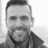

In [141]:
ima_init = Image.open("h.png").convert('L')
ori = ima_init.save("adv_Bouden_elouatiki_ori.png")
ima_init

In [142]:
#ckpt = tf.train.Checkpoint(step = tf.Variable(1), optimizer = optimizer, net = simple_cnn)
#ckpt.restore('./saved_model-1')

In [143]:
test.mean_accuracy(simple_cnn)

<tf.Tensor: shape=(), dtype=float32, numpy=0.862>

### Preprocess image

In [144]:
ima = np.array(ima_init,dtype=np.float32).reshape([1, 2304])
#ima = (ima - 128) / 256
pred = tf.nn.softmax(simple_cnn(ima,False))
pred.numpy()

array([[1., 0.]], dtype=float32)

### Mislead CNN detector

In [145]:
X = tf.constant(ima)  #Creates a constant tensor from a tensor-like object.
X

<tf.Tensor: shape=(1, 2304), dtype=float32, numpy=array([[211., 230., 247., ..., 124., 130., 183.]], dtype=float32)>

In [146]:
DXinit = tf.constant(0.0, shape=[1,2304])
DX = tf.Variable(DXinit)
DX

<tf.Variable 'Variable:0' shape=(1, 2304) dtype=float32, numpy=array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [147]:
#load a wrong label
wrong_label = [0.0,1.0]
wrong_label

[0.0, 1.0]

In [148]:
# Add a Variable DX to the input in your graph
DXinit = tf.constant(0.0, shape=[1,2304])
DX = tf.Variable(DXinit)
Xmod = X + DX

In [149]:
# Train only the DX Variable
tf.nn.log_softmax(simple_cnn(DX,False)).numpy()
optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.1)

In [181]:
#Show Modified Image and DX Image
modified_img = Image.fromarray(np.reshape((Xmod).numpy(),(48,48)))
DX_img = Image.fromarray(np.reshape((DX).numpy(),(48,48)))

In [188]:
# Save the Modified Image. Xmod
modified_img.convert('L').save("adv_Bouden_elouatiki_mod.png")
DX_img.convert('RGB').save("adv_Bouden_elouatiki_DX.png")

In [189]:
# As DX is very small, build an amplified image.
A = abs(DX)*50
A_img = Image.fromarray(np.reshape(A.numpy(),(48,48)))
A_img.convert('L').save("adv_Bouden_elouatiki_Amp.png")
A_img.show()

In [106]:
# Test the Modified Image with your small script.

In [190]:
def noise_one_iter(model, optimizer, X,label):
    with tf.GradientTape() as tape:
        y = model(X+DX,False)
        y = tf.nn.log_softmax(y)
        diff = label * y
        loss = -tf.reduce_sum(diff)
        grads = tape.gradient(loss,[DX]) 
        optimizer.apply_gradients(zip(grads, [DX]))
    return loss

In [191]:
optimizer = tf.optimizers.Adam(1e-3)

In [192]:
for iter in range(1000):
    with train_summary_writer.as_default():
        loss = noise_one_iter(simple_cnn, optimizer, X, wrong_label)
    if iter % 100 == 0:
        print("iter= %6d - loss= %f" % (iter, loss))

iter=      0 - loss= 1124.360352
iter=    100 - loss= 1111.641602
iter=    200 - loss= 1098.963623
iter=    300 - loss= 1086.121216
iter=    400 - loss= 1073.338623
iter=    500 - loss= 1060.796631
iter=    600 - loss= 1048.674927
iter=    700 - loss= 1036.809570
iter=    800 - loss= 1025.098633
iter=    900 - loss= 1013.538513


In [193]:
tf.nn.l2_loss([DX])

<tf.Tensor: shape=(), dtype=float32, numpy=3505.8145>

In [194]:
tf.nn.softmax(simple_cnn(X+DX,False))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

In [195]:
def noise_one_iter_regul(model, optimizer, beta, X,label):
    with tf.GradientTape() as tape:
        y = model(X+DX2,False)
        y = tf.nn.log_softmax(y)
        diff = label * y
        loss = -tf.reduce_sum(diff) + beta*tf.nn.l2_loss(DX2)
        grads = tape.gradient(loss,[DX2]) 
        optimizer.apply_gradients(zip(grads, [DX2]))
    return loss

In [196]:
# Loss function using L2 Regularization
DX2 = tf.Variable(DXinit)

In [197]:
for iter in range(1000):
    with train_summary_writer.as_default():
        loss = noise_one_iter_regul(simple_cnn, optimizer,0.01, X, wrong_label)
    if iter % 100 == 0:
        print("iter= %6d - loss= %f" % (iter, loss))

iter=      0 - loss= 1259.109985
iter=    100 - loss= 1209.768921
iter=    200 - loss= 1182.185669
iter=    300 - loss= 1161.289307
iter=    400 - loss= 1143.534180
iter=    500 - loss= 1127.877686
iter=    600 - loss= 1113.642700
iter=    700 - loss= 1100.263428
iter=    800 - loss= 1087.743042
iter=    900 - loss= 1076.093872


In [198]:
tf.nn.softmax(simple_cnn(X,False))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

In [199]:
tf.nn.softmax(simple_cnn(X+DX2,False))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

In [202]:
Delta_X2_m = Image.fromarray(np.reshape((abs(DX2)*50).numpy(),(48,48)))
Delta_X2_m.show()

In [168]:
if (tf.nn.l2_loss([DX2]) <= tf.nn.l2_loss([DX])):
    print('penalisation L2 OK')

In [203]:
Delta_X2_m.convert('L').save("adv_Bouden_elouatiki_DX_L2.png")